In [115]:
import pandas as pd
import os

# File path
file_path = os.path.join("./", "superstore_train.csv")

# Load the dataset with encoding fix
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Fix data types
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

categorical_cols = ['Category', 'Sub-Category', 'Segment', 'Region', 'Ship Mode', 'City', 'State', 'Country']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Quick preview
print(df.dtypes)
df.head()


Row ID                         int64
Order ID                      object
Order Date            datetime64[ns]
Ship Date             datetime64[ns]
Ship Mode                   category
Customer ID                   object
Customer Name                 object
Segment                     category
Country                     category
City                        category
State                       category
Postal Code                    int64
Region                      category
Product ID                    object
Category                    category
Sub-Category                category
Product Name                  object
Sales                        float64
Quantity                       int64
Discount                     float64
Profit                       float64
Shipping Delay                 int64
Discount Binned               object
Discounted Revenue           float64
Profit Margin                float64
dtype: object


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Delay,Discount Binned,Discounted Revenue,Profit Margin
0,4101,US-2017-102288,2017-06-19,2017-06-23,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,United States,Houston,...,Appliances,Holmes Visible Mist Ultrasonic Humidifier with...,2.264,1,0.8,-5.2072,4,41-100%,0.4528,-2.300
1,2587,CA-2017-131695,2017-06-30,2017-07-06,Standard Class,RA-19285,Ralph Arnett,Consumer,United States,New York City,...,Storage,Steel Personal Filing/Posting Tote,248.570,7,0.0,67.1139,6,No Discount,248.5700,0.270
2,9195,CA-2014-146843,2014-11-30,2014-12-06,Standard Class,PB-19150,Philip Brown,Consumer,United States,Avondale,...,Supplies,Acme Office Executive Series Stainless Steel T...,47.992,7,0.2,3.5994,6,11-20%,38.3936,0.075
3,2003,CA-2017-163510,2017-12-25,2017-12-28,Second Class,JW-15955,Joni Wasserman,Consumer,United States,Louisville,...,Storage,Fellowes Bankers Box Stor/Drawer Steel Plus,95.940,3,0.0,9.5940,3,No Discount,95.9400,0.100
4,7226,CA-2016-109953,2016-07-14,2016-07-18,Standard Class,RB-19360,Raymond Buch,Consumer,United States,San Francisco,...,Furnishings,Deflect-O Glasstique Clear Desk Accessories,30.800,4,0.0,10.1640,4,No Discount,30.8000,0.330


In [116]:
# Drop identifier and non-predictive columns
columns_to_drop = [
    'Row ID', 
    'Order ID', 
    'Customer ID', 
    'Customer Name', 
    'Product ID', 
    'Product Name'
]

# Drop Country only if it has a single unique value
if df['Country'].nunique() == 1:
    columns_to_drop.append('Country')

df.drop(columns=columns_to_drop, inplace=True)

# Confirm the drop
print("Remaining columns:")
print(df.columns)


Remaining columns:
Index(['Order Date', 'Ship Date', 'Ship Mode', 'Segment', 'City', 'State',
       'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Shipping Delay', 'Discount Binned',
       'Discounted Revenue', 'Profit Margin'],
      dtype='object')


In [117]:
import holidays
from datetime import timedelta

# Step 1: Extract time-based features
df['Order Month'] = df['Order Date'].dt.month_name().astype('category')
df['Order Quarter'] = df['Order Date'].dt.quarter.astype('category')
df['Order DayOfWeek'] = df['Order Date'].dt.day_name().astype('category')
df['Order Year'] = df['Order Date'].dt.year.astype('category')

# Step 2: Create custom list of discount-relevant US holidays
years = [2014, 2015, 2016, 2017]
us_holidays = holidays.US(years=years)

# Start with standard holidays relevant to retail
important_holidays = []

for date, name in us_holidays.items():
    if name in [
        "New Year's Day",
        "Presidents' Day",
        "Memorial Day",
        "Independence Day",
        "Labor Day",
        "Thanksgiving",
        "Christmas Day"
    ]:
        important_holidays.append(date)

# Add manually relevant retail dates
for y in years:
    important_holidays.append(pd.Timestamp(f"{y}-12-24"))  # Christmas Eve
    important_holidays.append(pd.Timestamp(f"{y}-12-31"))  # New Year's Eve

# Add Black Friday & Cyber Monday (based on Thanksgiving)
for date, name in us_holidays.items():
    if name == "Thanksgiving":
        black_friday = date + timedelta(days=1)
        cyber_monday = date + timedelta(days=4)
        important_holidays.extend([black_friday, cyber_monday])

# Step 3: Create holiday flag
important_holidays_str = set([d.strftime('%Y-%m-%d') for d in important_holidays])

df['Is Holiday Week'] = df['Order Date'].dt.strftime('%Y-%m-%d').isin(important_holidays_str)
df['Is Holiday Week'] = df['Is Holiday Week'].map({True: 'Yes', False: 'No'}).astype('category')

# Step 4: Drop raw date columns
df.drop(['Order Date', 'Ship Date'], axis=1, inplace=True)

# Step 5: Confirm result
print(df[['Order Month', 'Order DayOfWeek', 'Order Year', 'Is Holiday Week']].head())


  Order Month Order DayOfWeek Order Year Is Holiday Week
0        June          Monday       2017              No
1        June          Friday       2017              No
2    November          Sunday       2014              No
3    December          Monday       2017             Yes
4        July        Thursday       2016              No


In [118]:
# Define new file name and path
output_file = os.path.join("./", "superstore_modified_before_encoding.csv")

# Save to CSV (without the index column)
df.to_csv(output_file, index=False)

print(f"Modified dataset saved to: {output_file}")


Modified dataset saved to: ./superstore_modified_before_encoding.csv


In [119]:
df.dtypes
df.select_dtypes(include='category').columns.tolist()
for col in df.select_dtypes(include='category').columns:
    print(f"\n{col} — {df[col].nunique()} unique values")
    print(df[col].value_counts().head(10))



Ship Mode — 4 unique values
Ship Mode
Standard Class    4796
Second Class      1542
First Class       1225
Same Day           432
Name: count, dtype: int64

Segment — 3 unique values
Segment
Consumer       4170
Corporate      2427
Home Office    1398
Name: count, dtype: int64

City — 515 unique values
City
New York City    723
Los Angeles      594
Philadelphia     439
San Francisco    410
Seattle          355
Houston          299
Chicago          252
Columbus         172
San Diego        132
Springfield      132
Name: count, dtype: int64

State — 49 unique values
State
California        1579
New York           891
Texas              790
Pennsylvania       481
Washington         421
Illinois           402
Ohio               375
Florida            292
Michigan           203
North Carolina     193
Name: count, dtype: int64

Region — 4 unique values
Region
West       2554
East       2283
Central    1867
South      1291
Name: count, dtype: int64

Category — 3 unique values
Category
Office 

In [120]:
# Drop high-cardinality and overly granular columns and Is Holiday Week
df.drop(columns=['City', 'State', 'Sub-Category', 'Postal Code','Is Holiday Week'], inplace=True)

# Confirm drop
print("Remaining columns:")
print(df.columns)


Remaining columns:
Index(['Ship Mode', 'Segment', 'Region', 'Category', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Shipping Delay', 'Discount Binned',
       'Discounted Revenue', 'Profit Margin', 'Order Month', 'Order Quarter',
       'Order DayOfWeek', 'Order Year'],
      dtype='object')


In [121]:
missing = df.isnull().sum()
print(missing[missing > 0])

Series([], dtype: int64)


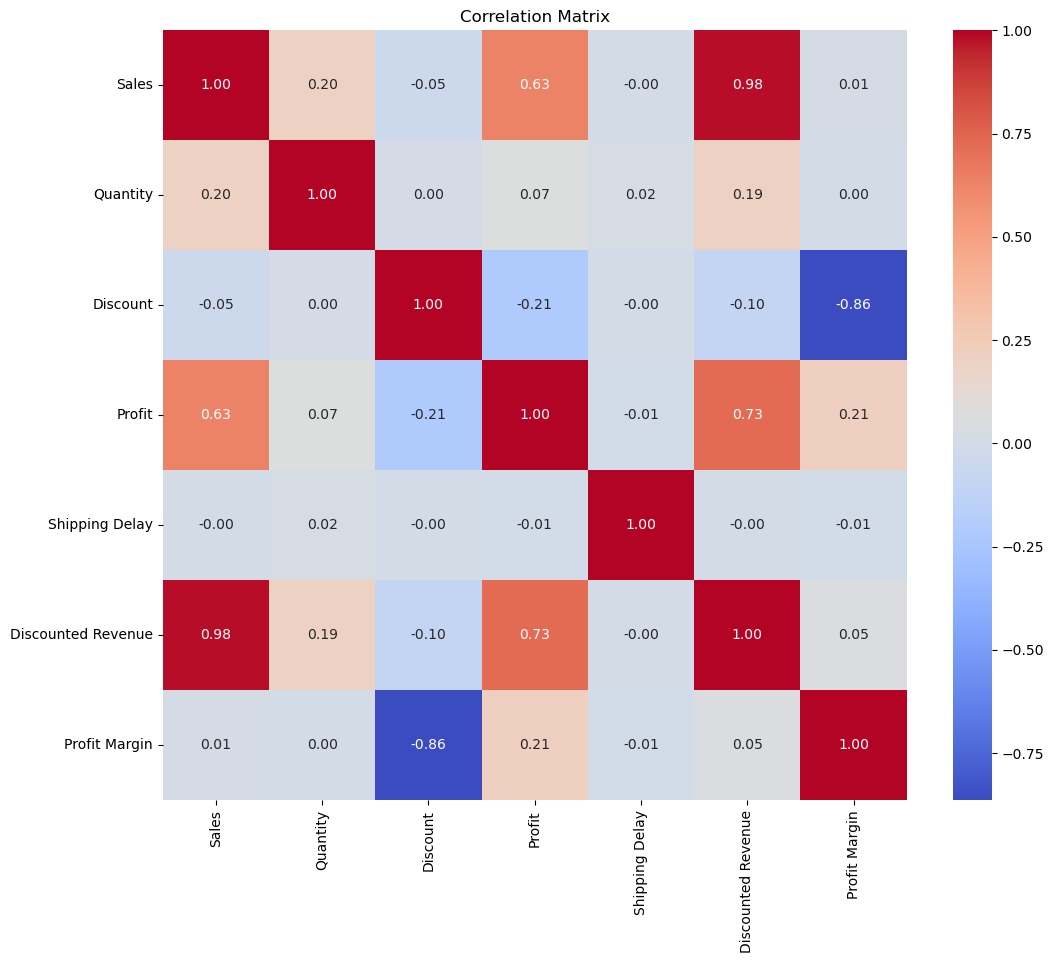

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


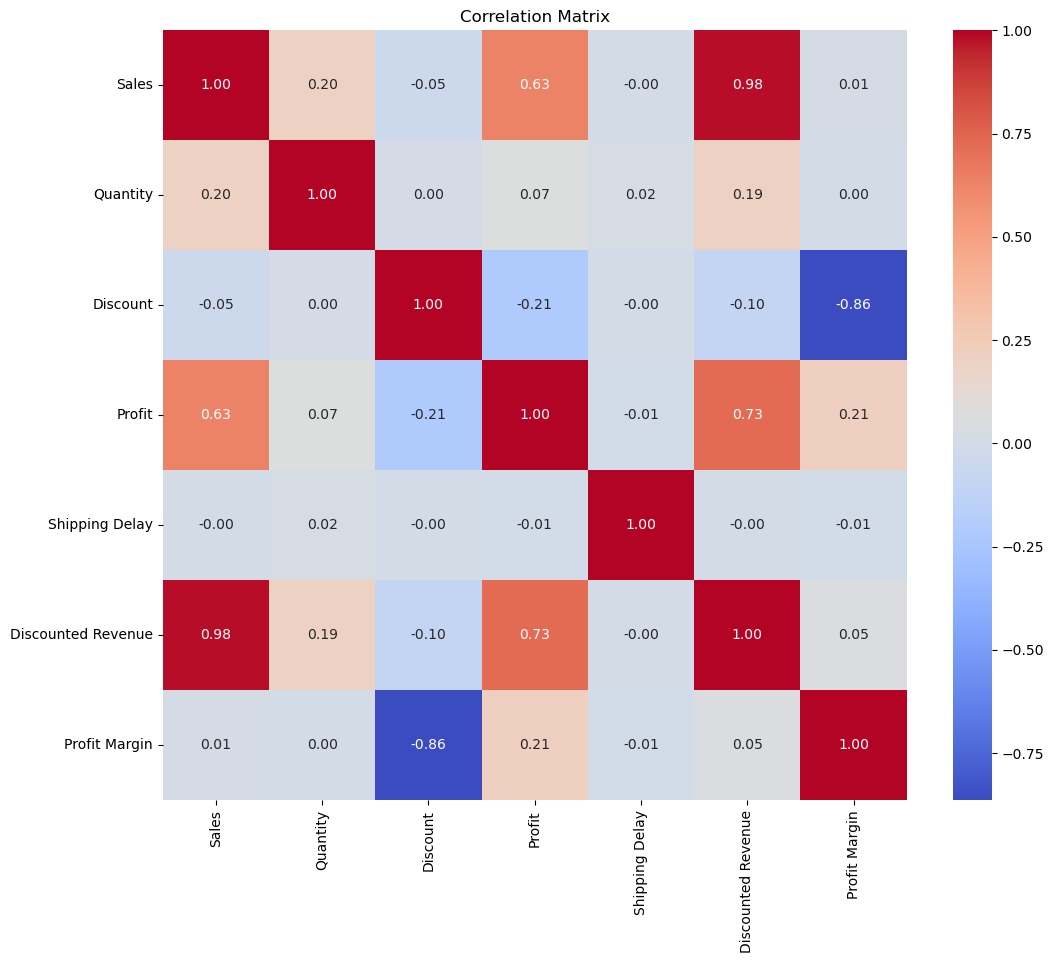


Highly Correlated Pairs (|r| > 0.8):
   Variable 1          Variable 2  Correlation
5       Sales  Discounted Revenue     0.983751
20   Discount       Profit Margin     0.864186


In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute correlation matrix (numerical columns only)
corr_matrix = df.corr(numeric_only=True)

# Step 2: Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Step 3: Extract pairs with correlation > 0.8 (and not 1.0)
# Stack the matrix, reset index, and rename columns
high_corr = corr_matrix.abs().stack().reset_index()
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Remove self-pairs and keep only one direction
high_corr = high_corr[high_corr['Variable 1'] != high_corr['Variable 2']]
high_corr = high_corr[high_corr['Correlation'] > 0.8]

# Drop duplicate pairs (A-B vs B-A)
high_corr['Pair'] = high_corr.apply(lambda row: tuple(sorted([row['Variable 1'], row['Variable 2']])), axis=1)
high_corr = high_corr.drop_duplicates(subset='Pair').drop(columns='Pair')

# Sort and display
high_corr = high_corr.sort_values(by='Correlation', ascending=False)
print("\nHighly Correlated Pairs (|r| > 0.8):")
print(high_corr)


In [124]:
# Drop derived/redundant columns
df.drop(columns=['Discounted Revenue', 'Profit Margin'], inplace=True)

# Confirm
print("Remaining columns:")
print(df.columns)


Remaining columns:
Index(['Ship Mode', 'Segment', 'Region', 'Category', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Shipping Delay', 'Discount Binned',
       'Order Month', 'Order Quarter', 'Order DayOfWeek', 'Order Year'],
      dtype='object')


In [125]:
# Step 0: Convert any object/bool columns meant for encoding to category
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'bool':
        df[col] = df[col].astype('category')

# Step 1: Identify categorical columns again
categorical_cols = df.select_dtypes(include='category').columns.tolist()

# Show their data types and unique value counts
for col in categorical_cols:
    print(f"\n🔍 {col} — {df[col].dtype} — {df[col].nunique()} unique values")
    print(df[col].unique())

# Step 2: One-hot encode with forced integer output (VIF-safe)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

# Step 3: Confirm final result
print(f"Shape after encoding: {df.shape}")
print("Column types after encoding:")
print(df.dtypes.value_counts())



🔍 Ship Mode — category — 4 unique values
['Standard Class', 'Second Class', 'First Class', 'Same Day']
Categories (4, object): ['First Class', 'Same Day', 'Second Class', 'Standard Class']

🔍 Segment — category — 3 unique values
['Consumer', 'Corporate', 'Home Office']
Categories (3, object): ['Consumer', 'Corporate', 'Home Office']

🔍 Region — category — 4 unique values
['Central', 'East', 'West', 'South']
Categories (4, object): ['Central', 'East', 'South', 'West']

🔍 Category — category — 3 unique values
['Office Supplies', 'Furniture', 'Technology']
Categories (3, object): ['Furniture', 'Office Supplies', 'Technology']

🔍 Discount Binned — category — 6 unique values
['41-100%', 'No Discount', '11-20%', '31-40%', '21-30%', '0-10%']
Categories (6, object): ['0-10%', '11-20%', '21-30%', '31-40%', '41-100%', 'No Discount']

🔍 Order Month — category — 12 unique values
['June', 'November', 'December', 'July', 'September', ..., 'October', 'May', 'August', 'January', 'February']
Length: 1

In [126]:
import numpy as np

corr_matrix = df.corr()
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and np.isclose(corr_matrix.loc[i, j], 1)]
print("Highly correlated pairs:", high_corr_pairs)

Highly correlated pairs: []


In [127]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Step 1: Drop the target variable (Profit)
X = df.drop(columns=['Profit'])

# Step 2: Add a constant for the intercept
X = add_constant(X)

# Step 3: Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Step 4: Round and sort VIF values
vif_data['VIF'] = vif_data['VIF'].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Step 5: Display
print("🔍 Variance Inflation Factors (VIF):")
print(vif_data)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🔍 Variance Inflation Factors (VIF):
                        Feature    VIF
21         Order Month_December    inf
30        Order Month_September    inf
22         Order Month_February    inf
20           Order Month_August    inf
26            Order Month_March    inf
24             Order Month_July    inf
28         Order Month_November    inf
29          Order Month_October    inf
23          Order Month_January    inf
31              Order Quarter_2    inf
32              Order Quarter_3    inf
33              Order Quarter_4    inf
3                      Discount  60.19
18      Discount Binned_41-100%  51.25
19  Discount Binned_No Discount  31.89
15       Discount Binned_11-20%  28.34
17       Discount Binned_31-40%   6.10
16       Discount Binned_21-30%   4.51
7      Ship Mode_Standard Class   3.97
4                Shipping Delay   3.16
6        Ship Mode_Second Class   2.01
27              Order Month_May   2.00
25             Order Month_June   1.95
13     Category_Office Suppl

In [128]:
import numpy as np

corr_matrix = X.corr()
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and np.isclose(corr_matrix.loc[i, j], 1)]
print("Highly correlated pairs:", high_corr_pairs)

Highly correlated pairs: []


In [129]:
# Drop one-hot encoded Order Quarter columns
quarter_cols = [col for col in df.columns if col.startswith('Order Quarter_')]
df.drop(columns=quarter_cols, inplace=True)

# Confirm drop
print("Dropped columns:", quarter_cols)


Dropped columns: ['Order Quarter_2', 'Order Quarter_3', 'Order Quarter_4']


In [130]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Step 1: Drop target variable (Profit)
X = df.drop(columns=['Profit'])

# Step 2: Add constant
X = add_constant(X)

# Step 3: Compute VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Step 4: Clean output
vif_data['VIF'] = vif_data['VIF'].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Step 5: Display
print("🔍 Updated VIF after dropping Order Quarter:")
print(vif_data)


🔍 Updated VIF after dropping Order Quarter:
                        Feature     VIF
0                         const  162.59
3                      Discount   60.19
18      Discount Binned_41-100%   51.25
19  Discount Binned_No Discount   31.89
15       Discount Binned_11-20%   28.34
17       Discount Binned_31-40%    6.10
16       Discount Binned_21-30%    4.51
7      Ship Mode_Standard Class    3.97
4                Shipping Delay    3.16
28         Order Month_November    2.77
21         Order Month_December    2.74
30        Order Month_September    2.71
29          Order Month_October    2.08
6        Ship Mode_Second Class    2.01
27              Order Month_May    2.00
24             Order Month_July    1.96
25             Order Month_June    1.95
26            Order Month_March    1.94
20           Order Month_August    1.94
13     Category_Office Supplies    1.93
39              Order Year_2017    1.88
38              Order Year_2016    1.80
12                  Region_West    1

In [131]:
# Drop all Discount Binned dummy variables
discount_bin_cols = [col for col in df.columns if col.startswith('Discount Binned_')]
df.drop(columns=discount_bin_cols, inplace=True)

# Confirm
print("Dropped columns:", discount_bin_cols)


Dropped columns: ['Discount Binned_11-20%', 'Discount Binned_21-30%', 'Discount Binned_31-40%', 'Discount Binned_41-100%', 'Discount Binned_No Discount']


In [132]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Step 1: Drop target variable (Profit)
X = df.drop(columns=['Profit'])

# Step 2: Add constant
X = add_constant(X)

# Step 3: Compute VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Step 4: Clean output
vif_data['VIF'] = vif_data['VIF'].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Step 5: Display
print("🔍 Updated VIF after dropping Order Quarter:")
print(vif_data)


🔍 Updated VIF after dropping Order Quarter:
                      Feature    VIF
0                       const  48.79
7    Ship Mode_Standard Class   3.97
4              Shipping Delay   3.16
23       Order Month_November   2.77
16       Order Month_December   2.73
25      Order Month_September   2.71
24        Order Month_October   2.08
6      Ship Mode_Second Class   2.01
22            Order Month_May   2.00
20           Order Month_June   1.95
19           Order Month_July   1.95
15         Order Month_August   1.94
21          Order Month_March   1.94
34            Order Year_2017   1.88
33            Order Year_2016   1.80
12                Region_West   1.72
32            Order Year_2015   1.71
26     Order DayOfWeek_Monday   1.66
10                Region_East   1.65
28     Order DayOfWeek_Sunday   1.64
27   Order DayOfWeek_Saturday   1.61
29   Order DayOfWeek_Thursday   1.58
13   Category_Office Supplies   1.57
14        Category_Technology   1.54
5          Ship Mode_Same Day  

In [133]:
import statsmodels.api as sm

# Step 1: Define target and features
y = df['Profit']
X = df.drop(columns=['Profit'])

# Step 2: Add constant for intercept
X = sm.add_constant(X)

# Step 3: Fit the OLS model
model = sm.OLS(y, X).fit()

# Step 4: View model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     189.6
Date:                Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:29:09   Log-Likelihood:                -52710.
No. Observations:                7995   AIC:                         1.055e+05
Df Residuals:                    7960   BIC:                         1.057e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

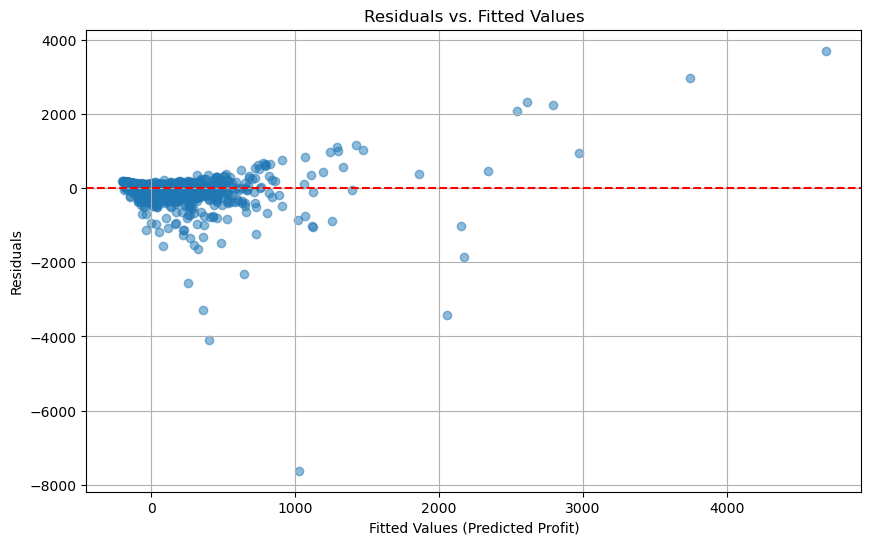

In [134]:
import matplotlib.pyplot as plt

# Get residuals and fitted values
fitted_vals = model.fittedvalues
residuals = model.resid

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predicted Profit)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.grid(True)
plt.show()


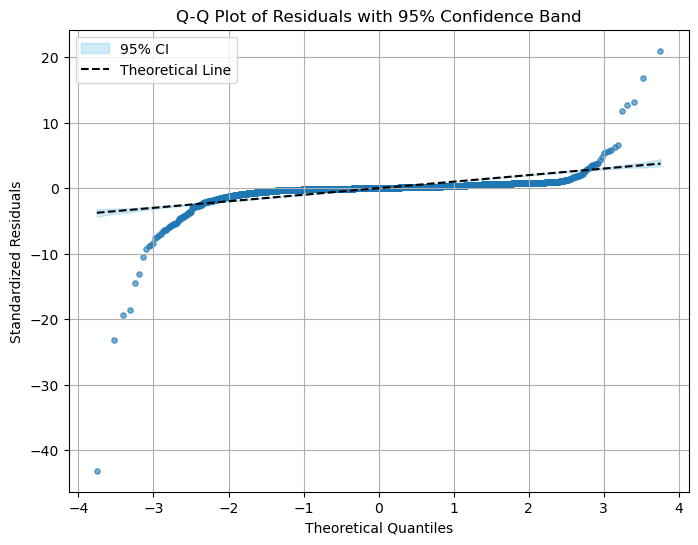

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Normalize residuals
residuals = model.resid
residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Get theoretical quantiles and ordered residuals
theoretical_q, sample_q = stats.probplot(residuals, dist="norm")

# Bootstrap for envelope
n = len(residuals)
simulated = np.array([np.sort(np.random.normal(size=n)) for _ in range(100)])
lower = np.percentile(simulated, 2.5, axis=0)
upper = np.percentile(simulated, 97.5, axis=0)

# Plot
plt.figure(figsize=(8, 6))
plt.fill_between(theoretical_q[0], lower, upper, color='skyblue', alpha=0.4, label='95% CI')
plt.plot(theoretical_q[0], theoretical_q[0], color='black', linestyle='--', label='Theoretical Line')
plt.scatter(theoretical_q[0], theoretical_q[1], alpha=0.6, s=15)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.title('Q-Q Plot of Residuals with 95% Confidence Band')
plt.legend()
plt.grid(True)
plt.show()


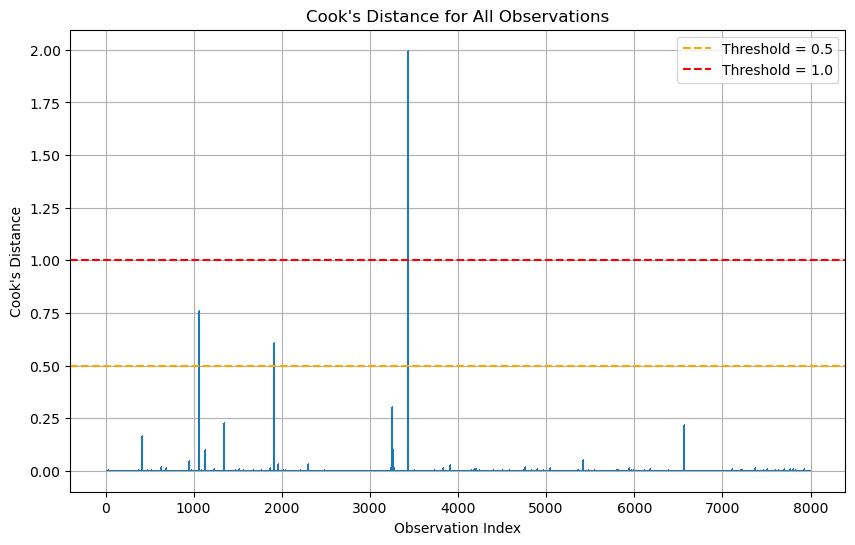

Number of highly influential points (Cook's D > 1): 1
Indices of most influential observations: [3429]


,Sales,Quantity,Discount,Profit,Shipping Delay,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,...,Order Month_September,Order DayOfWeek_Monday,Order DayOfWeek_Saturday,Order DayOfWeek_Sunday,Order DayOfWeek_Thursday,Order DayOfWeek_Tuesday,Order DayOfWeek_Wednesday,Order Year_2015,Order Year_2016,Order Year_2017
3429,17499.95,5,0.0,8399.976,7,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0


In [136]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get influence measures
influence = model.get_influence()

# Step 2: Extract Cook’s Distance and leverage
cooks_d = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag

# Step 3: Plot Cook’s Distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.axhline(y=0.5, color='orange', linestyle='--', label="Threshold = 0.5")
plt.axhline(y=1.0, color='red', linestyle='--', label="Threshold = 1.0")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for All Observations")
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Find most influential observations
influential_points = np.where(cooks_d > 1)[0]
print(f"Number of highly influential points (Cook's D > 1): {len(influential_points)}")
print("Indices of most influential observations:", influential_points[:10])  # preview first 10
df.iloc[influential_points]  # This will show you the full rows


In [165]:
# Create a copy of the original dataframe
df_cleaned = df.copy()

# Drop non-significant variables from the cleaned dataframe
non_significant = [
    'Shipping Delay', 'Ship Mode_Same Day', 'Ship Mode_Second Class', 'Ship Mode_Standard Class',
    'Segment_Corporate', 'Segment_Home Office', 'Region_South',
    'Order Month_August', 'Order Month_December', 'Order Month_February', 'Order Month_January',
    'Order Month_July', 'Order Month_June', 'Order Month_March', 'Order Month_May',
    'Order Month_November', 'Order Month_October', 'Order Month_September',
    'Order DayOfWeek_Monday', 'Order DayOfWeek_Saturday', 'Order DayOfWeek_Sunday',
    'Order DayOfWeek_Thursday', 'Order DayOfWeek_Tuesday', 'Order DayOfWeek_Wednesday',
    'Order Year_2015', 'Order Year_2016', 'Order Year_2017','Sales'
]

df_cleaned.drop(columns=non_significant, inplace=True)

# Confirm the changes
print("Original DataFrame Shape:", df.shape)
print("Cleaned DataFrame Shape:", df_cleaned.shape)
print("Columns in Cleaned DataFrame:", df_cleaned.columns)

Original DataFrame Shape: (7995, 35)
Cleaned DataFrame Shape: (7995, 7)
Columns in Cleaned DataFrame: Index(['Quantity', 'Discount', 'Profit', 'Region_East', 'Region_West',
       'Category_Office Supplies', 'Category_Technology'],
      dtype='object')


In [167]:
# Step 1: Define target and features
y = df_cleaned['Profit']
X = df_cleaned.drop(columns=['Profit'])

# Step 2: Add constant for intercept
X = sm.add_constant(X)

# Step 3: Fit the OLS model
model = sm.OLS(y, X).fit()

# Step 4: View model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     84.18
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          1.27e-102
Time:                        11:29:51   Log-Likelihood:                -54836.
No. Observations:                7995   AIC:                         1.097e+05
Df Residuals:                    7988   BIC:                         1.097e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [169]:
from sklearn.model_selection import train_test_split

X = df_cleaned.drop(columns=['Profit'])
y = df_cleaned['Profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [171]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [173]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

MAE: 61.534344993075855
MSE: 20103.08359270092
R-squared: -0.02587875929848371


In [175]:
import pandas as pd

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

# Sort and display
print(feature_importances.sort_values(ascending=False))

Quantity                    0.338180
Discount                    0.329897
Region_East                 0.124279
Region_West                 0.092394
Category_Technology         0.073710
Category_Office Supplies    0.041540
dtype: float64


In [181]:
# Create a new table df1 by removing 'Sales' from the original df
df1 = df.drop(columns=['Sales'])

# Verify the new table
print("Columns in df1:", df1.columns)

Columns in df1: Index(['Quantity', 'Discount', 'Profit', 'Shipping Delay',
       'Ship Mode_Same Day', 'Ship Mode_Second Class',
       'Ship Mode_Standard Class', 'Segment_Corporate', 'Segment_Home Office',
       'Region_East', 'Region_South', 'Region_West',
       'Category_Office Supplies', 'Category_Technology', 'Order Month_August',
       'Order Month_December', 'Order Month_February', 'Order Month_January',
       'Order Month_July', 'Order Month_June', 'Order Month_March',
       'Order Month_May', 'Order Month_November', 'Order Month_October',
       'Order Month_September', 'Order DayOfWeek_Monday',
       'Order DayOfWeek_Saturday', 'Order DayOfWeek_Sunday',
       'Order DayOfWeek_Thursday', 'Order DayOfWeek_Tuesday',
       'Order DayOfWeek_Wednesday', 'Order Year_2015', 'Order Year_2016',
       'Order Year_2017'],
      dtype='object')


In [183]:
from sklearn.model_selection import train_test_split

# Define target and features
X = df1.drop(columns=['Profit'])
y = df1['Profit']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [185]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

MAE: 68.86302810897206
MSE: 33577.60085113997
R-squared: -0.7134957103742097


In [187]:
import pandas as pd

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

# Sort and display
print(feature_importances.sort_values(ascending=False))

Shipping Delay               0.138223
Order Month_October          0.126259
Discount                     0.100199
Quantity                     0.099632
Order DayOfWeek_Thursday     0.062632
Category_Technology          0.053103
Order Year_2016              0.043051
Order Month_November         0.036270
Region_East                  0.032856
Order DayOfWeek_Sunday       0.032749
Order Month_December         0.031372
Order DayOfWeek_Saturday     0.027914
Order Month_March            0.024529
Order DayOfWeek_Tuesday      0.020023
Order Year_2017              0.017712
Order Month_September        0.013733
Order Month_July             0.013663
Ship Mode_Standard Class     0.013383
Order DayOfWeek_Monday       0.013133
Segment_Home Office          0.011675
Segment_Corporate            0.010703
Region_South                 0.010010
Order Year_2015              0.009708
Ship Mode_Second Class       0.008632
Order Month_January          0.007760
Order Month_February         0.007347
Region_West 

In [189]:
low_importance_vars = feature_importances[feature_importances < 0.01].index
df1 = df1.drop(columns=low_importance_vars)

In [191]:
high_importance_vars = feature_importances[feature_importances >= 0.01].index
df1 = df1[list(high_importance_vars) + ['Profit']]

In [193]:
# Example: Remove rows where Profit is outside the 1st and 99th percentiles
lower = df1['Profit'].quantile(0.01)
upper = df1['Profit'].quantile(0.99)
df1 = df1[(df1['Profit'] >= lower) & (df1['Profit'] <= upper)]

In [195]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(rf, param_grid, n_iter=10, cv=5, scoring='r2', random_state=42)
search.fit(X_train, y_train)

print("Best Parameters:", search.best_params_)
print("Best R-squared:", search.best_score_)

Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}
Best R-squared: 0.047683705760054006
